Not working yet

In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch
import time

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

import gym

C:\Users\Portable\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
env = gym.make('FrozenLake-v0')
nb_neurons = 50
temperature = 2000
learning_rate = 0.01
gamma = 0.8
e = 0.15

In [3]:
class brain(nn.Module):
    
    def __init__(self):
        super(brain,self).__init__()
        self.fc1 = nn.Linear(16,nb_neurons)
        self.fc2 = nn.Linear(nb_neurons,env.action_space.n)
    
    def forward(self,state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

In [4]:
class DQN():
    def __init__(self,gamma):
        self.model=brain()
        self.gamma = gamma
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        
    def select_action(self,state):
        #probs=F.softmax(self.model(torch.Tensor(state).detach())*temperature)
        #action = probs.multinomial(4)
        action = np.argmax(self.model(torch.Tensor(state).detach()).data)
        if np.random.rand(1)<e:
            action = env.action_space.sample()
        else:
            action = np.argmax(self.model(torch.Tensor(state).detach()).data)
        return action
    
    def learn(self, current_state, next_state,reward,action):
        #with torch.no_grad():
        output = self.model(current_state)
        #print(current_state.grad)
        #print(output)
        next_output = self.model(next_state).detach()
        #print(next_output)
        #print(next_output.detach().max()[0])
        target = (reward + self.gamma*(next_output.detach().max()[0])).detach()
        #print(next_output.requires_grad)
        td_loss = F.smooth_l1_loss(output[action], target)
        #td_loss = (output[action] - target)**2
        #print(td_loss)
        #print(td_loss)
        self.optimizer.zero_grad()
        td_loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        

In [5]:
number_episodes = 3000
ai = DQN(gamma)
all_reward = []

for episode in range(number_episodes):
    
    current_state=torch.randn(1,16,requires_grad=True)
    current_state = torch.Tensor(to_categorical(env.reset(), num_classes = 16))
    #print(current_state)
    #current_state = to_categorical(current_state, num_classes = 16)
    #print(ai.model(torch.Tensor(current_state)))
    cumulative_reward = 0
    for t in range(100):
        action = ai.select_action(current_state)
        next_state, reward, done, _ = env.step(np.int64(action))      
        next_state = to_categorical(next_state, num_classes = 16)
        if current_state[14]==1:
            print(reward)
            print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
        ai.learn(torch.Tensor(current_state),torch.Tensor(next_state),reward,action)
        if current_state[14]==1:
            print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
        cumulative_reward+=reward 
        #env.render()
        if done:
            break
        current_state = next_state
    #print(ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach()))
    all_reward.append(cumulative_reward)

C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0.0
tensor([ 0.0024,  0.0595,  0.0641, -0.0455], grad_fn=<ThAddBackward>)
tensor([ 0.0031,  0.0614,  0.1224, -0.0473], grad_fn=<ThAddBackward>)
1.0
tensor([ 0.0048,  0.0625,  0.1549, -0.0489], grad_fn=<ThAddBackward>)
tensor([ 0.0044,  0.0675,  0.2331, -0.0514], grad_fn=<ThAddBackward>)
0.0
tensor([-0.1904, -0.0913,  0.3106,  0.0304], grad_fn=<ThAddBackward>)
tensor([-0.1907, -0.0898,  0.2904,  0.0361], grad_fn=<ThAddBackward>)
0.0
tensor([-0.1914, -0.0888,  0.2755,  0.0414], grad_fn=<ThAddBackward>)
tensor([-0.1899, -0.0866,  0.2490,  0.0449], grad_fn=<ThAddBackward>)
0.0
tensor([-0.1883, -0.0846,  0.2245,  0.0479], grad_fn=<ThAddBackward>)
tensor([-0.1862, -0.0823,  0.1979,  0.0500], grad_fn=<ThAddBackward>)
0.0
tensor([-0.0971, -0.0193, -0.0088,  0.0387], grad_fn=<ThAddBackward>)
tensor([-0.0972, -0.0189, -0.0085,  0.0369], grad_fn=<ThAddBackward>)
1.0
tensor([-0.0974, -0.0206, -0.0082,  0.0352], grad_fn=<ThAddBackward>)
tensor([-0.1073, -0.0226, -0.0130,  0.0948], grad_fn=<ThAddBac

1.0
tensor([0.0493, 0.7848, 0.3786, 0.3534], grad_fn=<ThAddBackward>)
tensor([0.0538, 0.8319, 0.3869, 0.3615], grad_fn=<ThAddBackward>)
0.0
tensor([0.1126, 1.1234, 0.4742, 0.4411], grad_fn=<ThAddBackward>)
tensor([0.1057, 1.0923, 0.4650, 0.4322], grad_fn=<ThAddBackward>)
0.0
tensor([0.1057, 1.0923, 0.4650, 0.4322], grad_fn=<ThAddBackward>)
tensor([0.0881, 0.9631, 0.4340, 0.4022], grad_fn=<ThAddBackward>)
0.0
tensor([0.0723, 0.8645, 0.4060, 0.3752], grad_fn=<ThAddBackward>)
tensor([0.0562, 0.7659, 0.3770, 0.3472], grad_fn=<ThAddBackward>)
1.0
tensor([0.0562, 0.7659, 0.3770, 0.3472], grad_fn=<ThAddBackward>)
tensor([0.0450, 0.7079, 0.3577, 0.3286], grad_fn=<ThAddBackward>)
0.0
tensor([-0.0435,  0.2267,  0.1582,  0.1470], grad_fn=<ThAddBackward>)
tensor([-0.0434,  0.2274,  0.1578,  0.1465], grad_fn=<ThAddBackward>)
1.0
tensor([-0.0434,  0.2274,  0.1578,  0.1465], grad_fn=<ThAddBackward>)
tensor([-0.0455,  0.2560,  0.1650,  0.1531], grad_fn=<ThAddBackward>)
0.0
tensor([-0.0581,  0.4238,  0

0.0
tensor([0.1952, 0.4577, 0.2435, 0.5125], grad_fn=<ThAddBackward>)
tensor([0.1901, 0.4453, 0.2469, 0.4770], grad_fn=<ThAddBackward>)
1.0
tensor([0.1397, 0.3358, 0.1659, 0.2981], grad_fn=<ThAddBackward>)
tensor([0.1463, 0.3762, 0.1739, 0.3125], grad_fn=<ThAddBackward>)
0.0
tensor([0.1905, 0.6480, 0.2280, 0.4094], grad_fn=<ThAddBackward>)
tensor([0.1863, 0.6275, 0.2229, 0.4000], grad_fn=<ThAddBackward>)
0.0
tensor([0.1465, 0.3445, 0.1834, 0.3151], grad_fn=<ThAddBackward>)
tensor([0.1328, 0.3430, 0.1910, 0.3137], grad_fn=<ThAddBackward>)
0.0
tensor([0.0873, 0.3396, 0.1690, 0.3045], grad_fn=<ThAddBackward>)
tensor([0.0867, 0.3409, 0.1679, 0.3023], grad_fn=<ThAddBackward>)
1.0
tensor([0.0867, 0.3409, 0.1679, 0.3023], grad_fn=<ThAddBackward>)
tensor([0.0915, 0.3843, 0.1766, 0.3180], grad_fn=<ThAddBackward>)
0.0
tensor([0.1550, 0.6088, 0.2550, 0.4573], grad_fn=<ThAddBackward>)
tensor([0.1727, 0.5572, 0.2451, 0.4390], grad_fn=<ThAddBackward>)
0.0
tensor([0.0858, 0.2069, 0.1652, 0.2724], gra

0.0
tensor([0.0515, 0.1346, 0.1246, 0.0528], grad_fn=<ThAddBackward>)
tensor([0.0508, 0.1293, 0.1249, 0.0521], grad_fn=<ThAddBackward>)
0.0
tensor([0.0495, 0.1203, 0.1271, 0.0508], grad_fn=<ThAddBackward>)
tensor([0.0489, 0.1161, 0.1279, 0.0501], grad_fn=<ThAddBackward>)
1.0
tensor([0.0489, 0.1161, 0.1279, 0.0501], grad_fn=<ThAddBackward>)
tensor([0.0522, 0.1234, 0.1579, 0.0535], grad_fn=<ThAddBackward>)
0.0
tensor([0.0876, 0.2293, 0.2672, 0.0995], grad_fn=<ThAddBackward>)
tensor([0.0859, 0.2248, 0.2534, 0.1054], grad_fn=<ThAddBackward>)
0.0
tensor([0.0770, 0.1983, 0.1452, 0.0764], grad_fn=<ThAddBackward>)
tensor([0.0748, 0.1930, 0.1426, 0.0751], grad_fn=<ThAddBackward>)
0.0
tensor([0.0728, 0.1916, 0.1403, 0.0740], grad_fn=<ThAddBackward>)
tensor([0.0625, 0.1901, 0.1379, 0.0728], grad_fn=<ThAddBackward>)
0.0
tensor([0.0134, 0.1426, 0.1540, 0.0556], grad_fn=<ThAddBackward>)
tensor([0.0133, 0.1399, 0.1489, 0.0545], grad_fn=<ThAddBackward>)
0.0
tensor([0.0135, 0.1226, 0.1118, 0.0517], gra

1.0
tensor([0.1283, 0.2367, 0.2747, 0.1652], grad_fn=<ThAddBackward>)
tensor([0.1343, 0.2535, 0.3084, 0.1730], grad_fn=<ThAddBackward>)


In [6]:
learning = []
y = []
batch_size = 200
for i in range(0,len(all_reward),batch_size):
    learning.append(sum(all_reward[i:i+batch_size])/batch_size)
    y.append(i)

Text(0.5,1,'Evolution of the reward')

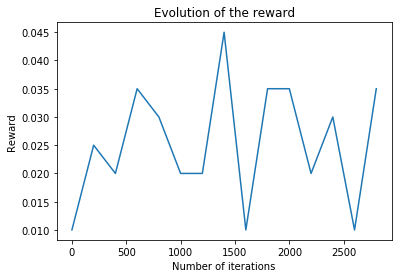

In [7]:
plt.plot(y,learning)
plt.ylabel('Reward')
plt.xlabel('Number of iterations')
plt.title('Evolution of the reward')

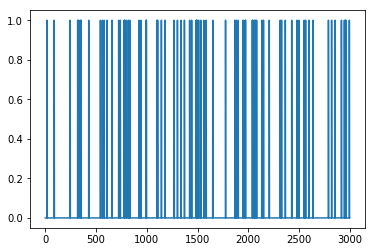

In [8]:
plt.plot(all_reward)

In [9]:
ai.model(torch.Tensor(to_categorical(14, num_classes = 16)).detach())

tensor([0.1866, 0.3791, 0.5641, 0.2316], grad_fn=<ThAddBackward>)